In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import cv2
import numpy as np
from os import listdir as ld
from os.path import join as pj
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data

# Dataset
from dataset.detection.dataset import insects_dataset_from_voc_style_txt, collate_fn
from IO.build_ds import build_classification_ds_from_result
# Loader
from IO.loader import load_path, load_images, load_annotations_path, load_annotations, get_anno_recs
# Predict
from model.refinedet.utils.predict import test_prediction as test_detection
from model.resnet.predict import test_classification
# utils
from IO.utils import refine_result_by_ovthresh
# Evaluate
from evaluation.det2cls.evaluate import evaluate, get_cls_accuracy_per_class
# Visualize
from evaluation.detection.visualize import plot_pr_curve
from evaluation.det2cls.visualize import vis_detections

# Test Config

In [3]:
class args:
    # paths
    data_root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
    test_image_root = "/home/tanida/workspace/Insect_Phenology_Detector/data/test_refined_images"
    det_model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/detection/RefineDet", "crop_b2_2_4_8_16_32_im512")
    divide_model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/classification/ResNet101", "resnet101_b20_r45_lr1e-5_crossvalid_divide_resize")
    cls_model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/classification/ResNet101", "resnet50_b20_r45_lr1e-5_crossvalid_resize")
    figure_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/figure/det2cls/RefineDet_ResNet", "refinedet_resnet50_resnet101_param1")
    test_anno_folders = ["annotations_4"]
    # training config
    div_model_name = "ResNet101"
    cls_model_name = "ResNet50"
    input_size = 512 # choices=[320, 512, 1024]
    crop_num = (5, 5)
    tcb_layer_num = 5
    rm_last = True
    # test config
    save_fig = True
    save_df = True
    add_div_model = True
    # class label
    div_labels =  ['Aquatic_insects', 'Other_insects']
    cls_labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
               'Lepidoptera', 'Plecoptera', 'Trichoptera']

# Model Config

In [4]:
if args.tcb_layer_num == 4 and args.rm_last == False:
    from model.refinedet.config import tcb_4_rm_false as insect_refinedet
elif args.tcb_layer_num == 4 and args.rm_last == True:
    from model.refinedet.config import tcb_4_rm_true as insect_refinedet
elif args.tcb_layer_num == 5 and args.rm_last == False:
    from model.refinedet.config import tcb_5_rm_false as insect_refinedet
elif args.tcb_layer_num == 5 and args.rm_last == True:
    from model.refinedet.config import tcb_5_rm_true as insect_refinedet
elif args.tcb_layer_num == 6 and args.rm_last == False:
    from model.refinedet.config import tcb_6_rm_false as insect_refinedet

# Set cuda

In [5]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# Detection Model

In [6]:
if args.rm_last == True:
    from model.refinedet.refinedet_rmlast import build_refinedet
else:
    from model.refinedet.refinedet import build_refinedet

In [7]:
det_model = build_refinedet('test', insect_refinedet, args.input_size, args.tcb_layer_num).cuda()
load_name = pj(args.det_model_root, 'RefineDet{}_{}.pth'.format(args.input_size, "final"))
det_model.load_state_dict(torch.load(load_name))

# Aquatic insect Classifier

In [8]:
if args.div_model_name=="ResNet18":
    from model.resnet.resnet18 import ResNet18
    div_model = ResNet18(len(args.div_labels)).cuda()
elif args.div_model_name=="ResNet34":
    from model.resnet.resnet34 import ResNet34
    div_model = ResNet34(len(args.div_labels)).cuda()
elif args.div_model_name=="ResNet50":
    from model.resnet.resnet50 import ResNet50
    div_model = ResNet50(len(args.div_labels)).cuda()
elif args.div_model_name=="ResNet101":
    from model.resnet.resnet101 import ResNet101
    div_model = ResNet101(len(args.div_labels)).cuda()
else:
    print("error! write correct model name!")
div_model.load_state_dict(torch.load(pj(args.divide_model_root, "final.pth")))

# Classification Model

In [9]:
if args.cls_model_name=="ResNet18":
    from model.resnet.resnet18 import ResNet18
    cls_model = ResNet18(len(args.cls_labels)).cuda()
elif args.cls_model_name=="ResNet34":
    from model.resnet.resnet34 import ResNet34
    cls_model = ResNet34(len(args.cls_labels)).cuda()
elif args.cls_model_name=="ResNet50":
    from model.resnet.resnet50 import ResNet50
    cls_model = ResNet50(len(args.cls_labels)).cuda()
elif args.cls_model_name=="ResNet101":
    from model.resnet.resnet101 import ResNet101
    cls_model = ResNet101(len(args.cls_labels)).cuda()
else:
    print("error! write correct model name!")
cls_model.load_state_dict(torch.load(pj(args.cls_model_root, "final.pth")))

### Make data

In [10]:
print('Loading dataset for test ...')
test_dataset = insects_dataset_from_voc_style_txt(args.test_image_root, args.input_size, args.crop_num, training=False)
test_data_loader = data.DataLoader(test_dataset, 1, num_workers=1, shuffle=False, collate_fn=collate_fn)
print('Loading annotation for test...')
annos, imgs = load_path(args.data_root, "refined_images", args.test_anno_folders)
images = load_images(imgs)
annotations_path = load_annotations_path(annos, images)
anno = load_annotations(annotations_path)
imagenames, recs = get_anno_recs(anno)

Loading dataset for test ...
Loading annotation for test...


### Get refinedet config

In [11]:
cfg = insect_refinedet[str(args.input_size)]

# --- result analysis ---

In [12]:
result = test_detection(det_model, test_data_loader, args.crop_num, nms_thresh=0.3)

In [13]:
result = refine_result_by_ovthresh(result, ovthresh=0.3)

In [14]:
insect_dataset = build_classification_ds_from_result(images, result, use_resize=True)

In [15]:
for image_id, imgs in insect_dataset.items():
    imgs = torch.from_numpy(imgs).cuda()
    cls_lbls = test_classification(cls_model, imgs, bs=20)
    divide_lbls = test_classification(div_model, imgs, bs=20)
    result[image_id].update({"output_lbl": cls_lbls})
    result[image_id].update({"divide_lbl": divide_lbls})

In [16]:
# arrange index to label
# not considered label = -1
name2lbl = {
    'Coleoptera': -1, 
    'Diptera': 0, 
    'Ephemeridae': 1, 
    'Ephemeroptera': 2, 
    'Hemiptera': -1, 
    'Lepidoptera': 3, 
    'Plecoptera': 4, 
    'Trichoptera': 5, 
    'medium insect': -1, 
    'small insect': -1, 
    'snail': -1, 
    'spider': -1
}

In [17]:
recall, precision, avg_precision, gt_dict = evaluate(result, recs, name2lbl, 0.3)

### --- visualize accuracy distribution of size ---

In [18]:
df = pd.DataFrame({"precision": precision, "recall": recall})
if args.save_df is True:
    df.to_csv(pj(args.figure_root, "pr_curve_df.csv"))
df

,precision,recall
0,0.001605,1.000000
1,0.003210,1.000000
2,0.004815,1.000000
3,0.006421,1.000000
4,0.008026,1.000000
...,...,...
635,0.202247,0.340541
636,0.202247,0.340541
637,0.202247,0.339623
638,0.202247,0.338710


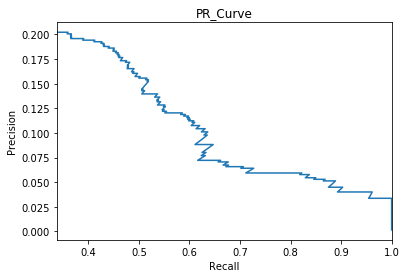

In [19]:
plot_pr_curve(df, args.figure_root, save=False)

### --- visualize cls accuracy ---

In [45]:
accs, recalls, precisions = get_cls_accuracy_per_class(cls_model, insect_dataset, result, gt_dict, name2lbl, add_divide_model=args.add_div_model)

In [46]:
np.mean(accs)

0.6539010088352193

In [47]:
np.mean(recalls)

0.7982310700052636

In [48]:
np.mean(precisions)

0.7152263802263802

In [51]:
accs

[0.7878787878787878,
 0.7083333333333334,
 0.55,
 0.7,
 0.5625,
 0.8333333333333334,
 0.6111111111111112,
 0.5714285714285714,
 0.47368421052631576,
 0.7407407407407407]

In [49]:
recalls

array([0.78181818, 0.69230769, 0.58064516, 0.85      , 1.        ,
       0.88461538])

In [50]:
precisions

array([0.57333333, 1.        , 0.48648649, 0.85      , 0.46153846,
       0.92      ])

### --- compare ground truth and output ---

In [26]:
im_index = 0
if os.path.exists(args.figure_root) is False:
    os.makedirs(args.figure_root)

In [27]:
colors = ["white", "red", "lime", "blue", "yellow", "fuchsia", "aqua", "gray", "maroon", "green", "navy", "olive", "purple", "teal"]
insect_name =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 'Lepidoptera', 'Plecoptera', 'Trichoptera', 'Coleoptera', 'Hemiptera', 'medium insect', 'small insect']
# arrange index to label
# not considered label = -1
# to see ground truth, use medium and small label
name2lbl = {
    'Coleoptera': -1, 
    'Diptera': 0, 
    'Ephemeridae': 1, 
    'Ephemeroptera': 2, 
    'Hemiptera': -1, 
    'Lepidoptera': 3, 
    'Plecoptera': 4, 
    'Trichoptera': 5, 
    'medium insect': -1, 
    'small insect': -1, 
    'snail': -1, 
    'spider': -1
}

In [38]:
img = np.asarray(Image.open(pj("/home/tanida/workspace/Insect_Phenology_Detector/data/refined_images", imagenames[im_index]+".png")))
for i in range(len(insect_name)):
    lbl_filter = result[imagenames[im_index]]['output_lbl'] == i
    result_coord_filtered_by_lbl = result[imagenames[im_index]]['coord'][lbl_filter]
    gt_lbls = np.asarray([name2lbl[name] for name in gt_dict[imagenames[im_index]]['default_name']])
    lbl_filter = gt_lbls == i
    gt_coord_filtered_by_lbl = gt_dict[imagenames[im_index]]['bbox'][lbl_filter]
    
    img = vis_detections(img, result_coord_filtered_by_lbl, class_name=insect_name[i], color_name=colors[i])
    img = vis_detections(img, gt_coord_filtered_by_lbl, class_name=insect_name[i], color_name=colors[i])

img = Image.fromarray(img)
img.save(pj(args.figure_root, imagenames[im_index]+".png"))
print(imagenames[im_index])
im_index += 1

IndexError: list index out of range